### Exercise 7.04: Implementing the GAN

In [1]:
import tensorflow as tf
import numpy as np
from numpy.random import randn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

#### realData function

In [6]:
# Function to generate real samples
def realData(loc,batch):
    # loc is the random location or mean around which samples are centered
    # Numbers to the right of loc
    xr = np.arange(loc,loc+(0.1*batch/2),0.1)
    xr = xr[0:int(batch/2)]
    # Numbers to the left of loc
    xl = np.arange(loc-(0.1*batch/2),loc,0.1)
    # Concatenate both series
    X1 = np.concatenate((xl,xr))
    # Second dependent variable
    X2 = np.sin(X1)
    # Reshaping both variables and concatenating them into array of independent variables
    X1 = X1.reshape(batch,1)
    X2 = X2.reshape(batch,1)
    X = np.concatenate((X1,X2),axis=1)
    # Generating the labels for real data set which is 'ones'
    y = np.ones((batch,1))
    return X,y

#### Functions to generate fake samples

##### fakeInputs function

In [7]:
# Function to generate inputs for generator function
def fakeInputs(batch,infeats):
    # Sample data points equal to (batch * input feature size)
    genInput = randn(infeats * batch)
    # Reshape the input
    X = genInput.reshape(batch,infeats)
    return X

##### genModel function

In [8]:
# Function for the generator model
def genModel(infeats,outfeats):
    # Defining the Generator model
    # layer 1
    Genmodel = Sequential()
    Genmodel.add(Dense(
        32,
        activation='linear',
        kernel_initializer='he_uniform',
        input_dim=infeats
    ))
    
    # layer 2
    Genmodel.add(Dense(
        32,
        activation='relu',
        kernel_initializer='he_uniform'
    ))
    
      # layer 3
    Genmodel.add(Dense(
        64,
        activation='elu',
        kernel_initializer='he_uniform'
    ))
    
      # layer 4
    Genmodel.add(Dense(
        32,
        activation='elu',
        kernel_initializer='he_uniform'
    ))
    
      # layer 5
    Genmodel.add(Dense(
        32,
        activation='selu',
        kernel_initializer='he_uniform'
    ))
    
      # layer 6
    Genmodel.add(Dense(
        outfeats,
        activation='selu'
    ))
    return Genmodel


##### fakedataGenerator function

In [9]:
# Function to create fake samples using the generator model
def fakedataGenerator(Genmodel,batch,infeats):
    # Generate inputs to the model
    genInputs = fakeInputs(batch,infeats)
    # Use inputs inside generator model to generate fake distribution
    X_fake = Genmodel.predict(genInputs)
    # Generate the labels of the fake data set
    y_fake = np.zeros((batch,1))
    return X_fake, y_fake

##### End of function definitions

In [10]:
# Parameters to be used in the functions above
batch,infeats,outfeats = 128, 10, 2

In [11]:
# Build discriminator model
Discmodel = Sequential()

# layer 1
Discmodel.add(Dense(
    16,
    activation='relu',
    kernel_initializer='he_uniform',
    input_dim=outfeats
))

# layer 2
Discmodel.add(Dense(
    16,
    activation='relu',
    kernel_initializer='he_uniform'
))

# layer 3
Discmodel.add(Dense(
    16,
    activation='relu',
    kernel_initializer='he_uniform'
))

# layer 4
Discmodel.add(Dense(
    1,
    activation='sigmoid'
))

# Compiling model
Discmodel.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

2022-07-19 07:10:29.259972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [12]:
Discmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                48        
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 609
Trainable params: 609
Non-trainable params: 0
_________________________________________________________________


In [13]:
# Calling Generator model function
Genmodel = genModel(infeats, outfeats)
Genmodel.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                352       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 64)                2112      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 2)                 66        
                                                                 
Total params: 6,722
Trainable params: 6,722
Non-traina

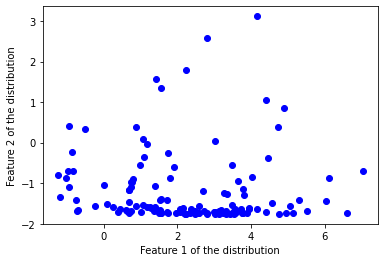

In [14]:
# visualize initial fake data
x_fake, _ = fakedataGenerator(Genmodel, batch, infeats)
# Plotting fake data using pyplot
plt.scatter(x_fake[:,0], x_fake[:,1], color='blue')
# Adding x and y labels
plt.xlabel('Feature 1 of the distribution')
plt.ylabel('Feature 2 of the distribution')
plt.show()

##### ganModel
Combined generator and discriminator model, for updating the generator

In [15]:
def ganModel(Genmodel, Discmodel):
    # Discmodel not trainable
    Discmodel.trainable = False
    Ganmodel = Sequential()
    # Adding generator model
    Ganmodel.add(Genmodel)
    # Adding Discmodel without parameters
    Ganmodel.add(Discmodel)
    # Compile the model for loss to optimise the Generator model
    Ganmodel.compile(loss='binary_crossentropy', optimizer='adam')
    return Ganmodel

In [16]:
# Initialise the gan model
gan_model = ganModel(Genmodel, Discmodel)

In [17]:
# Print summary of gan_model
gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 2)                 6722      
                                                                 
 sequential (Sequential)     (None, 1)                 609       
                                                                 
Total params: 7,331
Trainable params: 6,722
Non-trainable params: 609
_________________________________________________________________


Notice that gan_model is just a wrapper of the generator and discriminator models.

In [18]:
# Define number of epochs
nEpochs = 20000

In [19]:
# Train the GAN network
for i in range(nEpochs):
    # Generate the random number for generating real samples
    loc = np.random.normal(3,1,1)
    # Generate samples equal to the batch size from the real distribution
    x_real, y_real = realData(loc, batch)
    # Generate fake samples using the fake data generator function
    x_fake, y_fake = fakedataGenerator(Genmodel, batch, infeats)
    # Train the discriminator on the real samples
    Discmodel.train_on_batch(x_real, y_real)
    # Train the discriminator on the fake samples
    Discmodel.train_on_batch(x_fake, y_fake)
    # Generate new fake inputs for training the GAN network
    x_gan = fakeInputs(batch, infeats)
    # Create labels of the fake examples as 1 to fool the discriminator
    y_gan = np.ones((batch, 1))
    # Update the generator model through the discriminator model
    gan_model.train_on_batch(x_gan, y_gan)
    # Print the accuracy measures on the real and fake data for every 2000 epochs
    if (i) % 2000 == 0:
        # Generate samples equal to the batch size of the real distribution
        x_real, y_real = realData(loc, batch)
        # Evaluate Real distribution accuracy
        _, realAccuracy = Discmodel.evaluate(x_real, y_real, verbose=0)
        # Generate fake samples using the fake data generator function
        x_fake, y_fake = fakedataGenerator(Genmodel, batch, infeats)
        # Evaluate fake distribution accuracy levels
        _, fakeAccuracy = Discmodel.evaluate(x_fake, y_fake, verbose=0)
        print('Real accuracy:{R}, Fake accuracy:{F}'.format(R=realAccuracy, F=fakeAccuracy))
        # Scatter plot for real and fake data points
        plt.scatter(x_real[:, 0], x_real[:, 1], color='red')
        plt.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
        plt.xlabel('Feature 1 of the distribution')
        plt.ylabel('Feature 2 of the distribution')
        # Save plot to file
        filename = 'GAN_training_plot%03d.png' % (i)
        plt.savefig(filename)
        plt.close()

Real accuracy:1.0, Fake accuracy:0.0078125
Real accuracy:0.34375, Fake accuracy:1.0
Real accuracy:0.4765625, Fake accuracy:1.0
Real accuracy:0.6015625, Fake accuracy:1.0
Real accuracy:0.4765625, Fake accuracy:0.984375
Real accuracy:0.359375, Fake accuracy:0.9765625
Real accuracy:0.203125, Fake accuracy:1.0
Real accuracy:0.21875, Fake accuracy:0.9921875
Real accuracy:0.296875, Fake accuracy:1.0
Real accuracy:0.046875, Fake accuracy:0.9765625
